<a href="https://colab.research.google.com/github/Mun-Robbery/NLP/blob/main/disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00


In [65]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict
from collections import Counter
from typing import List
import string

import seaborn as sns
sns.set(palette='summer')


In [45]:
nltk.download('punkt')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antrisole","key":"f640a223d90f428a09658502f16db9e2"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [7]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 1.40MB/s]
100% 593k/593k [00:00<00:00, 1.40MB/s]


In [8]:
!unzip nlp-getting-started

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [27]:
tweet= pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [28]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


<ipython-input-36-596335cdb198>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x, palette="pastel")


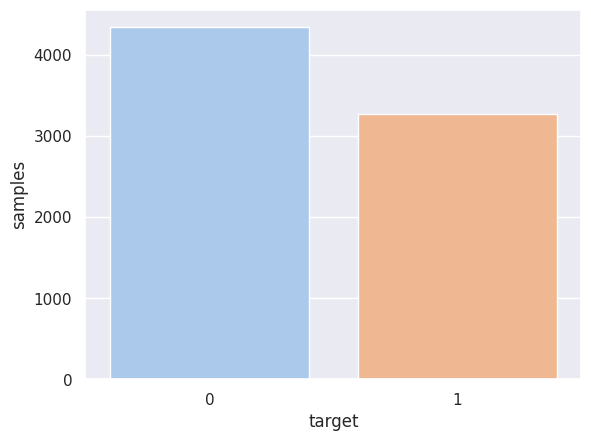

In [36]:
x=tweet.target.value_counts()
sns.barplot(x, palette="pastel")
plt.gca().set_ylabel('samples')


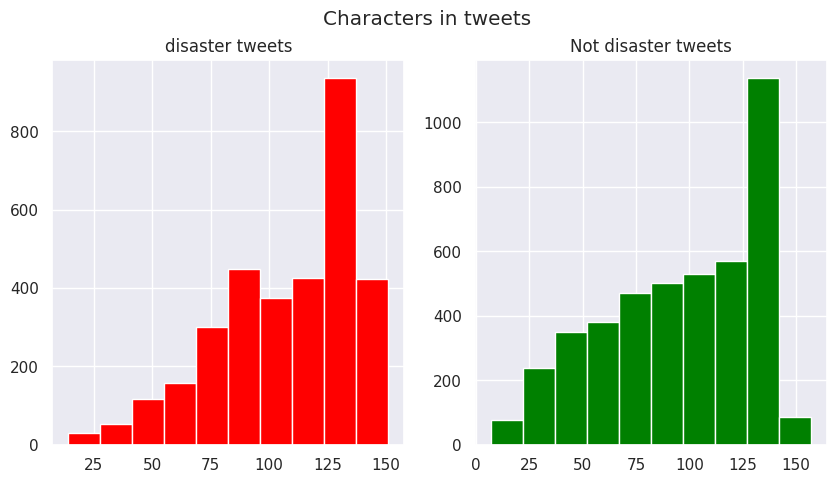

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

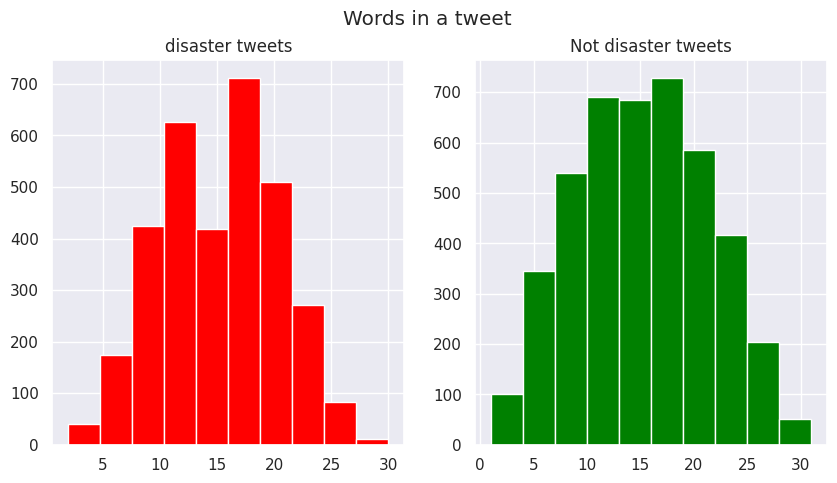

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

<ipython-input-39-14a9464123af>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
<ipython-input-39-14a9464123af>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each tweet')

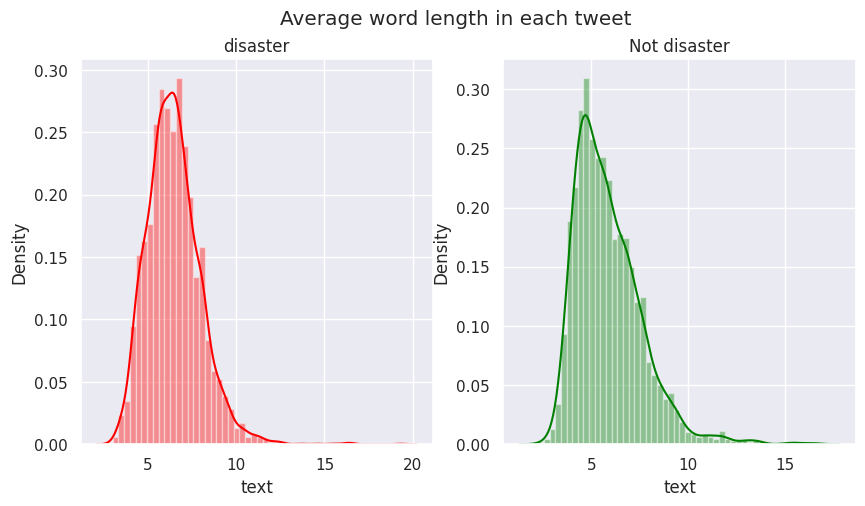

In [39]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [47]:
def create_corpus(target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

Class 0

In [48]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

<BarContainer object of 10 artists>

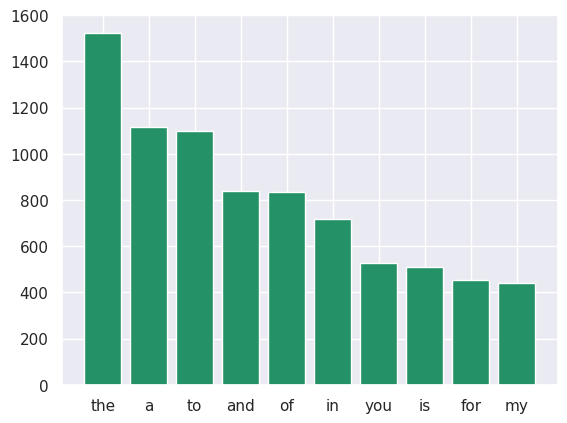

In [49]:
x,y=zip(*top)
plt.bar(x,y)

Class 1

<BarContainer object of 10 artists>

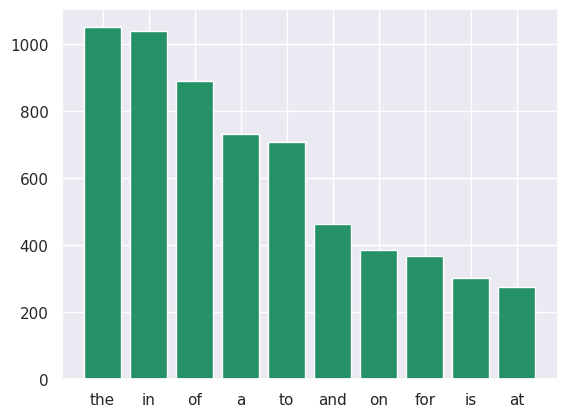

In [51]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]



x,y=zip(*top)
plt.bar(x,y)

Class 1

<BarContainer object of 18 artists>

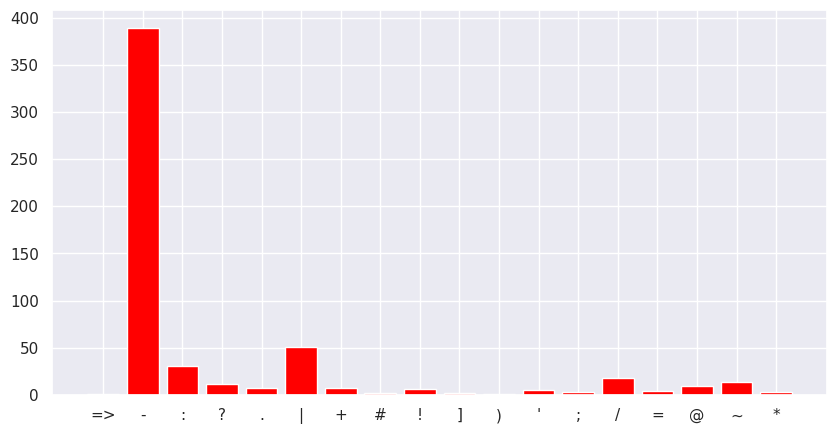

In [54]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y,color='red')

class 0

<BarContainer object of 20 artists>

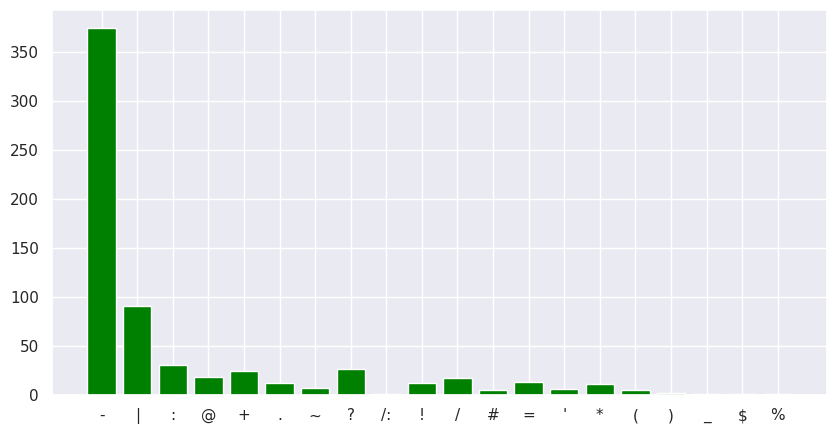

In [53]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [55]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<ipython-input-57-639a4064d999>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x,palette='pastel')


<Axes: >

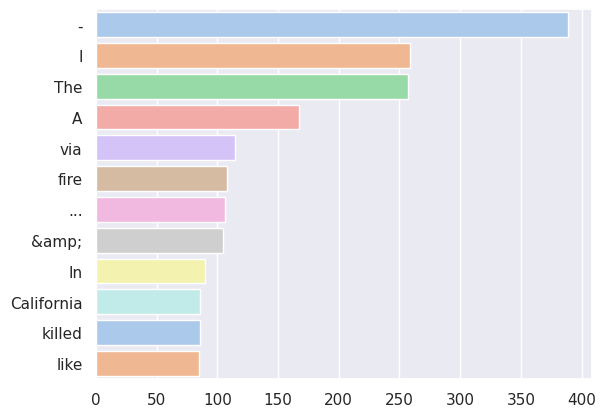

In [57]:
sns.barplot(x=y,y=x,palette='pastel')

#Ngram analysis

In [59]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<ipython-input-61-214a5d722ff2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y,y=x,palette='pastel')


<Axes: >

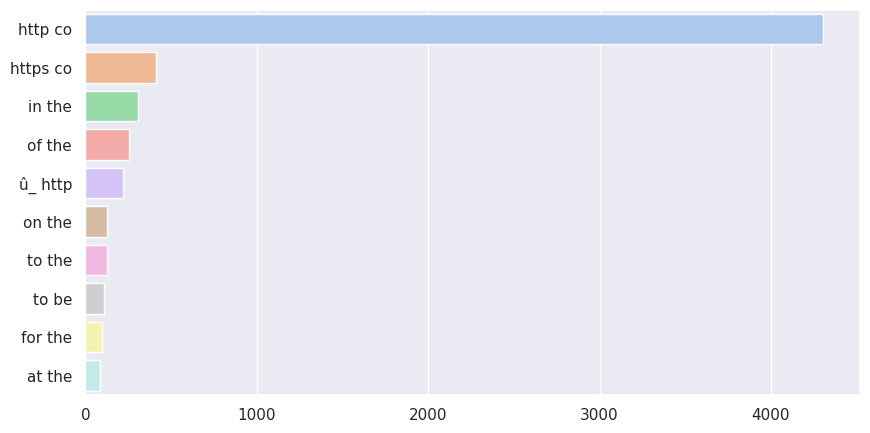

In [61]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x,palette='pastel')

#Data Cleaning

In [62]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

**Removing urls**

In [63]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [66]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [67]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

**Removing HTML tags**

In [69]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [70]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [71]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [72]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [73]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

**Removing punctuations**

In [74]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [75]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

**Spelling Correction**

In [76]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.9 MB/s eta 0:00:00


In [77]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

text = "corect me plese"
correct_spellings(text)

'correct me please'

In [81]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

#GloVe for Vectorization

In [82]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus


In [83]:
corpus=create_corpus(df)

  0%|          | 0/10876 [00:00<?, ?it/s]

In [84]:
embedding_dict={}
with open('/content/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [87]:
sentences = []
word_threshold = 30

# Получить отдельные предложения и поместить их в sentences
for article in tqdm(df["text"]):
    token_article = nltk.tokenize.sent_tokenize(article)
    for sentence in token_article:
        token_sentence = nltk.tokenize.word_tokenize(sentence)
        if len(token_sentence) <= word_threshold:
            stop_words = set(nltk.corpus.stopwords.words("english"))
            token_sentence = [word for word in token_sentence if word.isalnum() and word not in stop_words]
            sentences.append(token_sentence)

for article in tqdm(df["text"]):
    token_article = nltk.tokenize.sent_tokenize(article)
    for sentence in token_article:
        token_sentence = nltk.tokenize.word_tokenize(sentence)
        if len(token_sentence) <= word_threshold:
            stop_words = set(nltk.corpus.stopwords.words("english"))
            token_sentence = [word for word in token_sentence if word.isalnum() and word not in stop_words]
            sentences.append(token_sentence)

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

In [88]:
len(sentences)

21746

In [89]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in sentence:
        words[word] += 1

  0%|          | 0/21746 [00:00<?, ?it/s]

In [96]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
threshold = 1
vocab_size = 12072

for word, count in words.items():
    if count > threshold:
        vocab.add(word)
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 27350


In [97]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [98]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence.append(self.bos_id)
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [99]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [100]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.1)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction


In [ ]:
model = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind[''])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM_GRU(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind[''])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
